In [1]:
import cv2	
import	numpy as np
import matplotlib.pyplot as plt
import os
from numba import jit
import timeit


In [2]:
def extract_color_signature(img_path):
    
    img = cv2.imread(img_path)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    pixels = np.float32(img.reshape(-1, 3))

    #Werte normalisieren
    pixels[:, 0] /= 100.0  
    pixels[:, 1:] += 128.0  
    pixels[:, 1:] /= 255.0	    
    # 8 cluster
    k=6
    # Abbruchkritereien (komische opencv kacke, "+"" weil beide kriterien gelten, 100 Durchläufe, 0.1 epsilon)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1)
    # k=8 cluster, keine Labels, Abbruchkriterien von oben, 10 Durchläufe mit anderen Zentren, zufällige center
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)

    # Gewichte berechnen
    unique_labels, counts = np.unique(labels, return_counts=True)
    weights = np.zeros(k)
    for i, label in enumerate(unique_labels):
        weights[label] = counts[i]
    weights = weights / np.sum(weights)  # Normalisierung
    
    # Werte entnormalisieren
    centers[:, 0] *= 100.0  
    centers[:, 1:] *= 255.0
    centers[:, 1:] -= 128.0 
    
    #zurück in BGR
    bgr_centers = []
    for center in centers:
        # Reshape für cv2.cvtColor
        lab_color = center.reshape(1, 1, 3)
        bgr_color = cv2.cvtColor(lab_color.astype(np.uint8), cv2.COLOR_Lab2BGR)
        bgr_centers.append(bgr_color[0, 0])
    
    return np.array(bgr_centers), weights



In [3]:

def visualize_color_signature(centers, weights, figsize=(10, 4)):
    """
    Visualisiert eine Farbsignatur.
    
    Parameters:
    -----------
    centers : numpy.ndarray
        Die k repräsentativen Farben
    weights : numpy.ndarray
        Die relative Häufigkeit jeder Farbe
    """
    # Sortiere Farben nach Gewicht (absteigend)
    sorted_indices = np.argsort(weights)[::-1]
    sorted_centers = centers[sorted_indices]
    sorted_weights = weights[sorted_indices]
    
    # Erstelle Farbbalken
    plt.figure(figsize=figsize)
    
    # Jede Farbe als Balken darstellen
    for i, (center, weight) in enumerate(zip(sorted_centers, sorted_weights)):
        # Konvertiere BGR zu RGB für matplotlib
        rgb_color = center[::-1] / 255.0  # BGR zu RGB und auf [0, 1] normalisieren
        plt.bar(i, weight, color=rgb_color, width=0.8)
        
        # Prozentsatz anzeigen
        plt.text(i, weight + 0.01, f"{weight*100:.1f}%", 
                 ha='center', va='bottom', fontsize=9)
    
    plt.xlabel('Farbcluster')
    plt.ylabel('Relative Häufigkeit')
    plt.title('Farbsignatur des Bildes')
    plt.xticks([])  # x-Achse ohne Zahlen
    plt.ylim(0, max(weights) * 1.2)  # Ein wenig Platz über dem höchsten Balken
    plt.show()

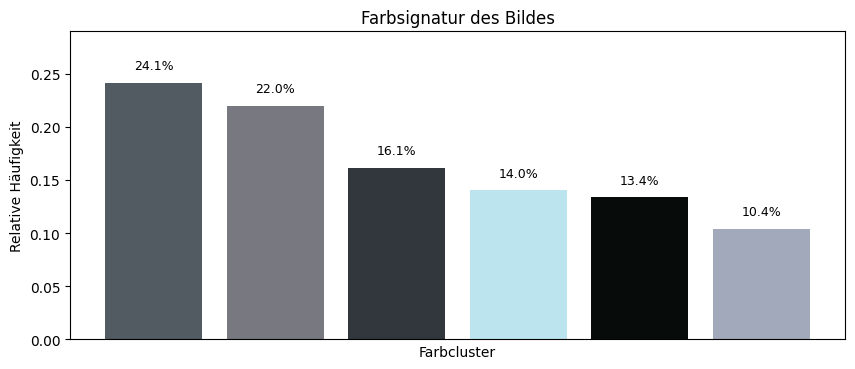

array([[186, 169, 161],
       [ 60,  55,  49],
       [238, 228, 188],
       [ 10,  11,   7],
       [129, 120, 120],
       [ 98,  90,  82]], dtype=uint8)

In [4]:
os.getcwd()
image = "my_test_file.jpg"
filepath = os.path.join(os.getcwd(), image)
centers, weights = extract_color_signature(filepath)
visualize_color_signature(centers, weights)
centers

In [5]:
def compare_images(weights1, centers1, weights2, centers2):

  

    weights1 = np.array(weights1, dtype=np.float32)
    weights2 = np.array(weights2, dtype=np.float32)
    centers1 = np.array(centers1, dtype=np.float32)
    centers2 = np.array(centers2, dtype=np.float32)


    signature1 = np.column_stack((weights1, centers1))
    signature2 = np.column_stack((weights2, centers2))


    distance, _,_ = cv2.EMD(signature1,signature2,cv2.DIST_L1)

    return distance



In [6]:

filepath1 = os.path.join(os.getcwd(), "Schwan.jpeg")
filepath2 = os.path.join(os.getcwd(), "Schwan.jpeg")
centers1, weights1 = extract_color_signature(filepath1)
centers2, weights2 = extract_color_signature(filepath2)




In [ ]:
dauer = timeit.timeit(lambda : compare_images(weights1, centers1, weights2, centers2), number=10000)

dauer

2.2671541000017896